In [1]:
import torch 
import torch as th 
import torch.nn as nn
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Prep training data

In [2]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [4]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


### Example experiment

In [5]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [6]:
!ls {exproot}

BaseBlnr_RAVEN10_abstract_20240212-2142
BaseBlnr_RAVEN10_abstract_onehot_20240212-2143
BaseBlnrX3_new_RAVEN10_abstract_20240313-1736
BaseBlnrX3_new_RAVEN10_abstract_onehot_20240313-1736
base_cifar10_20240130-2317
base_cifar10_20240130-2318
base_gabor_prime_20240130-2251
base_gabor_sf_20240130-2306
base_mnist_20240129-1342
base_mnist_20240129-1406
base_mnist_20240130-2207
base_RAVEN10_20240131-2049
base_RAVEN10_abstract_20240201-0036
Base_RAVEN10_abstract_20240212-2139
base_RAVEN10_abstract_onehot_20240201-0147
Base_RAVEN10_abstract_onehot_20240212-2140
BBigBlnrX3_new_RAVEN10_abstract_20240313-1809
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240313-1810
BBigBlnrX3_new_RAVEN10_abstract_onehot_20240314-0112
BBigBlnrX3_RAVEN10_abstract_20240305-2341
BigBlnrlrsm_RAVEN10_abstract_onehot_20240209-1411
BigBlnr_RAVEN10_abstract_20240208-1709
BigBlnr_RAVEN10_abstract_onehot_20240209-0208
BigBlnrX3_new_RAVEN10_abstract_20240313-1753
BigBlnrX3_new_RAVEN10_abstract_20240315-1328
BigBlnrX3_new_RAVEN10_

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_RAVEN10_abstract_20240315-1327"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [ ]:
!ls {repr_dir}

In [14]:
def sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99], 
                            epoch_list=[-1, 20000, 40000, 100000, 200000, 500000, 700000,]):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            if epoch == -1:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckptRNDINIT.pkl"), "rb"))
            else:
                results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckpt{epoch:07d}EMA.pkl"), "rb"))
            test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
            train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
            syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
            syn_df.columns = ["Test Accuracy", "Train Accuracy"]
            syn_df["t"] = t_scalar
            syn_df["epoch"] = epoch
            # drop index as layer name
            syn_df = syn_df.reset_index()
            syn_df = syn_df.rename(columns={"index": "Layer"})
            syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    return syn_df_all

In [11]:
syn_df_all = []
# t_scalar = 0.1
for t_scalar in [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]:
    for epoch in [-1, 20000, 40000, 100000, 200000, 500000, 700000,]:
        t_str = str(t_scalar).replace(".", "_")
        if epoch == -1:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckptRNDINIT.pkl"), "rb"))
        else:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC512_ckpt{epoch:07d}EMA.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["t"] = t_scalar
        syn_df["epoch"] = epoch
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

In [13]:
syn_df_all

,Layer,Test Accuracy,Train Accuracy,t,epoch
0,input,0.237075,0.264167,0.05,-1
1,enc.9x9_conv,0.227775,0.275992,0.05,-1
2,enc.3x3_down,0.272750,0.328925,0.05,-1
3,enc.1x1_down,0.110125,0.116692,0.05,-1
4,dec.1x1_in0,0.118050,0.123825,0.05,-1
...,...,...,...,...,...
6,dec.3x3_up,0.623250,0.641467,0.99,700000
7,dec.9x9_up,0.727100,0.791583,0.99,700000
8,dec.9x9_block2,0.513625,0.572175,0.99,700000
9,dec.9x9_aux_norm,0.486000,0.543350,0.99,700000


<Axes: xlabel='Layer', ylabel='Test Accuracy'>

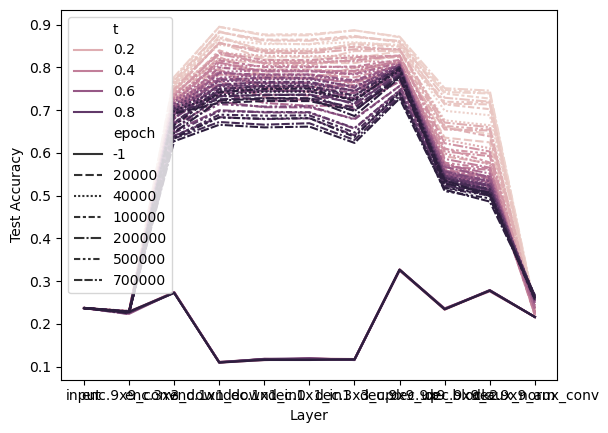

In [15]:

sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="t", style="epoch")

# syn_df_all.plot(x="Layer", y="Test Accuracy", hue="t", logy=True, figsize=(12, 8))

<Axes: xlabel='Layer', ylabel='Test Accuracy'>

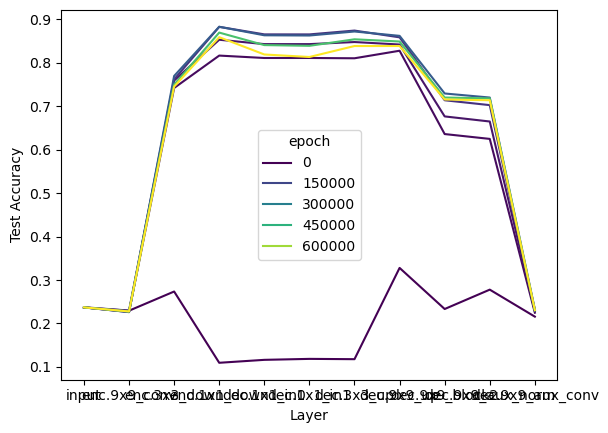

In [18]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], x="Layer", y="Test Accuracy", hue="epoch", palette="viridis")

<Axes: xlabel='epoch', ylabel='Test Accuracy'>

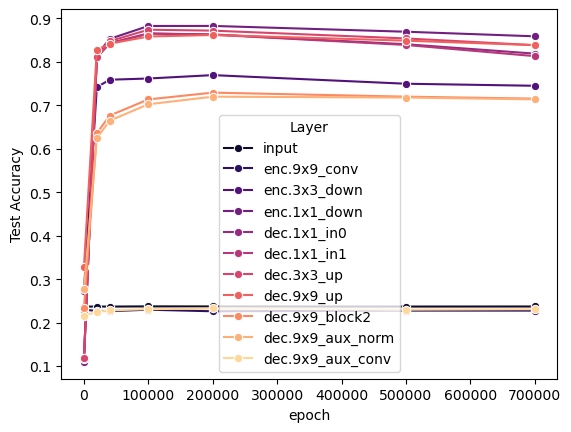

In [26]:
sns.lineplot(data=syn_df_all[syn_df_all["t"]==0.1], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma")

In [29]:
syn_df_all["epoch"].unique()

array([    -1,  20000,  40000, 100000, 200000, 500000, 700000])

<Axes: xlabel='t', ylabel='Test Accuracy'>

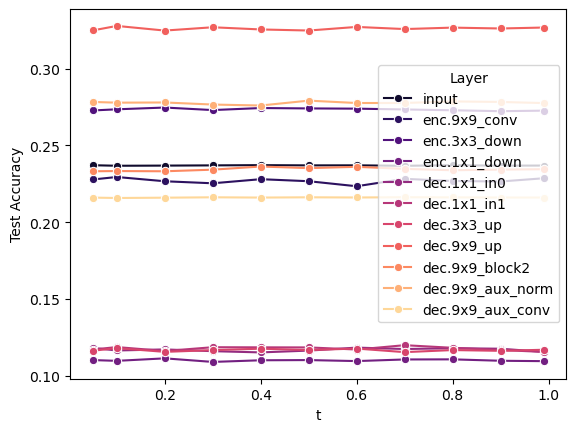

In [31]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==-1], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='t', ylabel='Test Accuracy'>

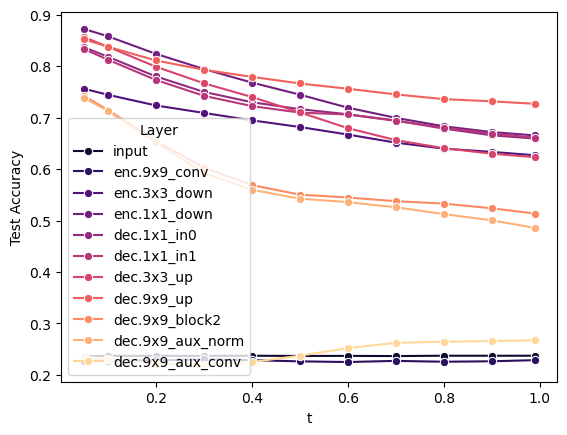

In [30]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==700000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='t', ylabel='Test Accuracy'>

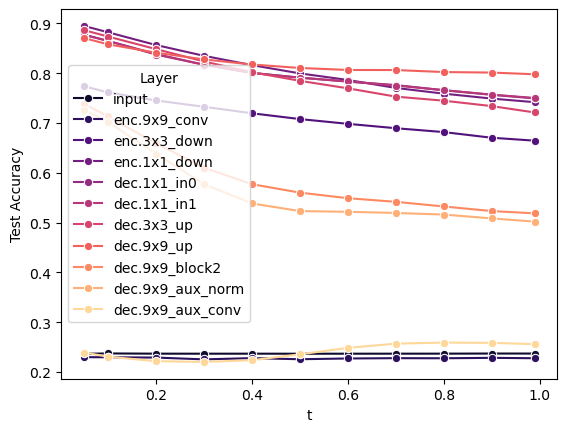

In [27]:
sns.lineplot(data=syn_df_all[syn_df_all["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", palette="magma")

<Axes: xlabel='Layer', ylabel='Test Accuracy'>

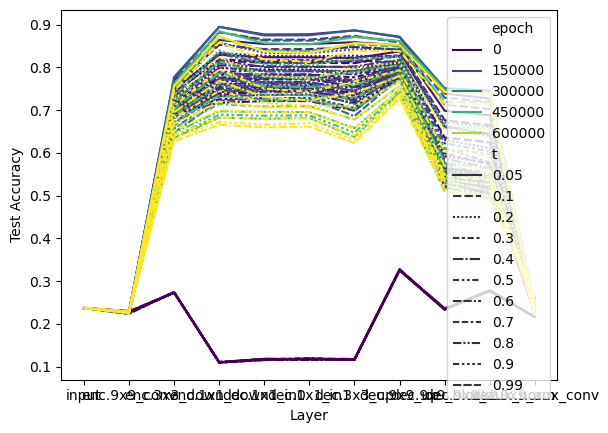

In [17]:
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="epoch", style="t", palette="viridis")

In [38]:
syn_df_all["Test Accuracy"].max()
# find the row with max test accuracy
syn_df_all[syn_df_all["Test Accuracy"] == syn_df_all["Test Accuracy"].max()]

,Layer,Test Accuracy,Train Accuracy,t,epoch
3,enc.1x1_down,0.894875,0.917942,0.05,100000


In [39]:
syn_df_all["Test Accuracy"].max()

0.894875

In [35]:
syn_df_all["Train Accuracy"].max()

0.9398916666666667

In [41]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"BaseBlnrX3_new_RAVEN10_abstract_20240313-1736"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
# ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_base = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/BaseBlnrX3_new_RAVEN10_abstract_20240313-1736/repr_classifier/results_col_t0_05_PC512_ckptRNDINIT.pkl'

### Wide model

In [48]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_wide = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

FileNotFoundError: [Errno 2] No such file or directory: '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240412-1347/repr_classifier/results_col_t0_05_PC512_ckptRNDINIT.pkl'

In [50]:
!ls {expdir}

checkpoints		      panel_minL1dist_dict.pt
consistency_new_stats_df.csv  row_minL1dist_dict.pt
dataset_idx.pkl		      samples
inpaint_pilot		      samples_inferred_rule_consistency_new.npz
loss_curve.png		      std.log
memorization_stats.csv


### No-attr wide model

In [11]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"WideBlnrX3_new_noattn_RAVEN10_abstract_20240412-1254"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_wide_noattr = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

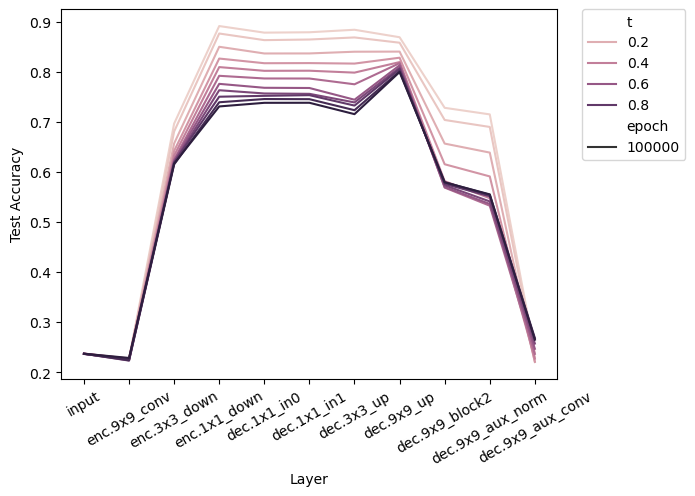

In [33]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

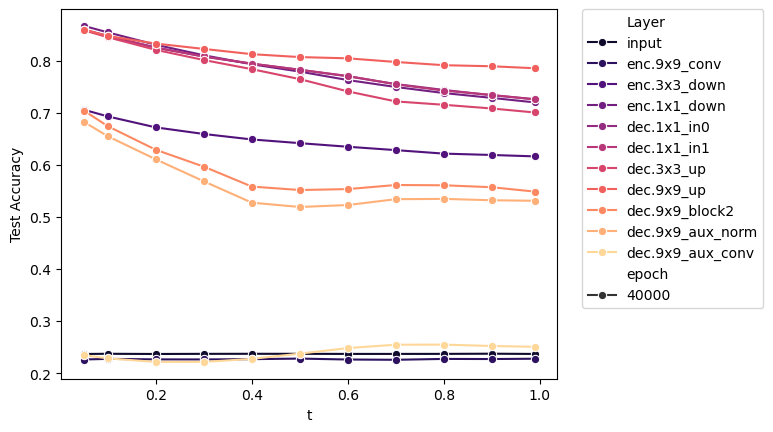

In [28]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

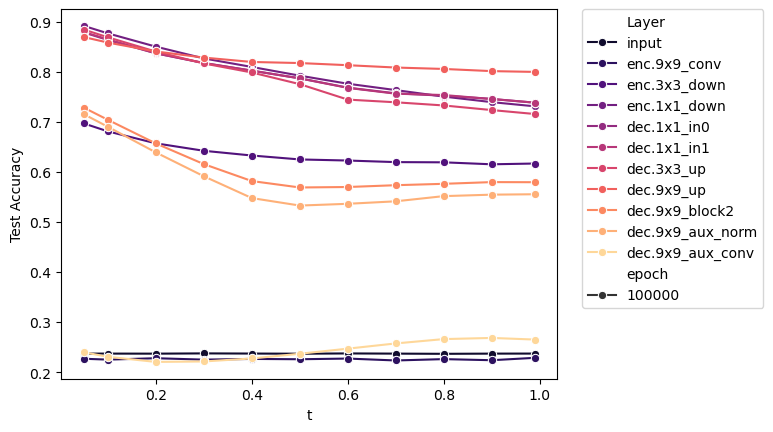

In [27]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==100000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

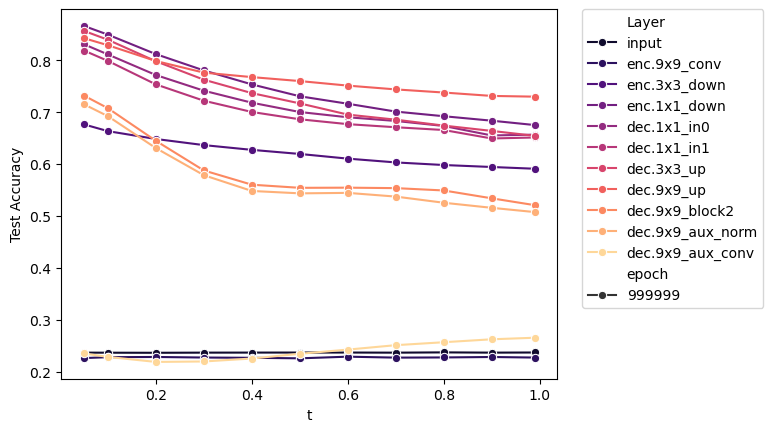

In [26]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["epoch"]==999999], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

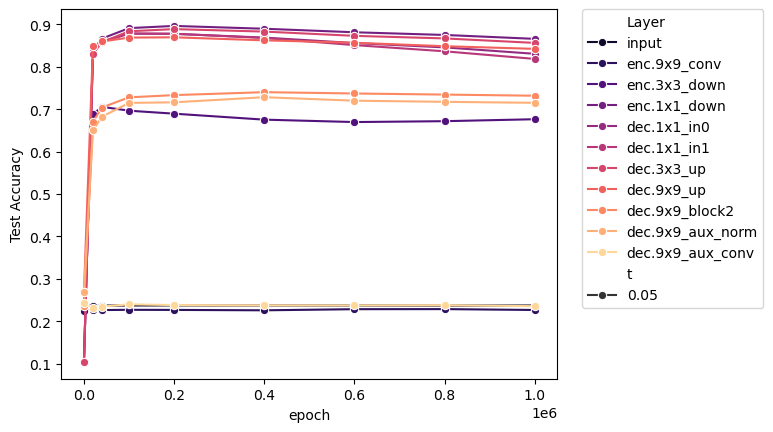

In [47]:
sns.lineplot(data=syn_df_all_wide_noattr[syn_df_all_wide_noattr["t"]==0.05], marker="o",
             x="epoch", y="Test Accuracy", hue="Layer", palette="magma", style="t")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Big model

In [34]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
expname = r"BigBlnrX3_new_RAVEN10_abstract_20240412-0143"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
ckpt_path = join(ckptdir, "1000000.pt")
syn_df_all_big = sweep_classifier_result(repr_dir, t_list=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],
                                epoch_list=[-1, 20000, 40000, 100000, 200000, 400000, 600000, 800000, 999999])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

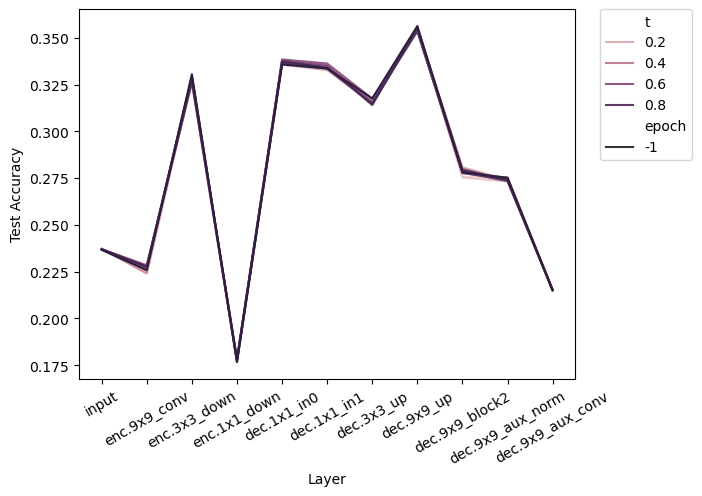

In [39]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==-1], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'input'),
  Text(1, 0, 'enc.9x9_conv'),
  Text(2, 0, 'enc.3x3_down'),
  Text(3, 0, 'enc.1x1_down'),
  Text(4, 0, 'dec.1x1_in0'),
  Text(5, 0, 'dec.1x1_in1'),
  Text(6, 0, 'dec.3x3_up'),
  Text(7, 0, 'dec.9x9_up'),
  Text(8, 0, 'dec.9x9_block2'),
  Text(9, 0, 'dec.9x9_aux_norm'),
  Text(10, 0, 'dec.9x9_aux_conv')])

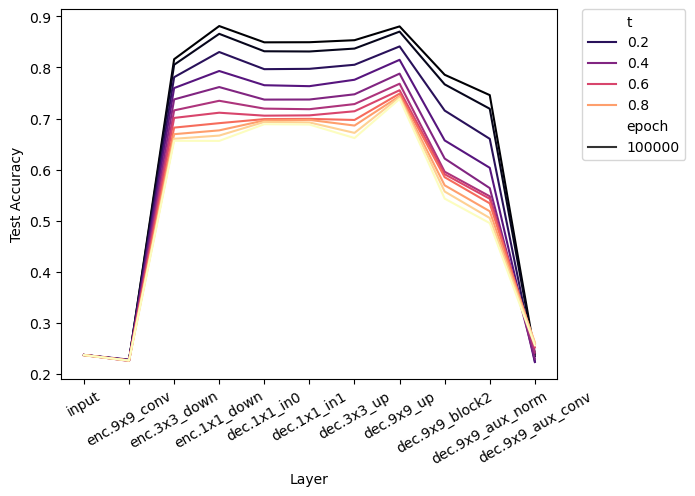

In [40]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==100000], 
             x="Layer", y="Test Accuracy", hue="t", style="epoch",palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=30)

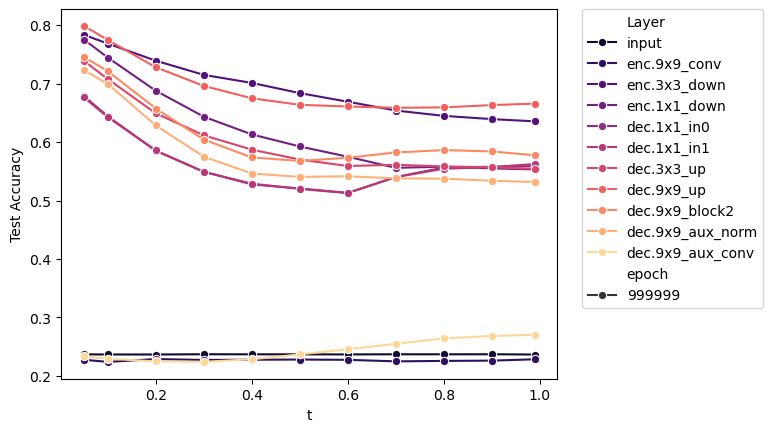

In [36]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==999999], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

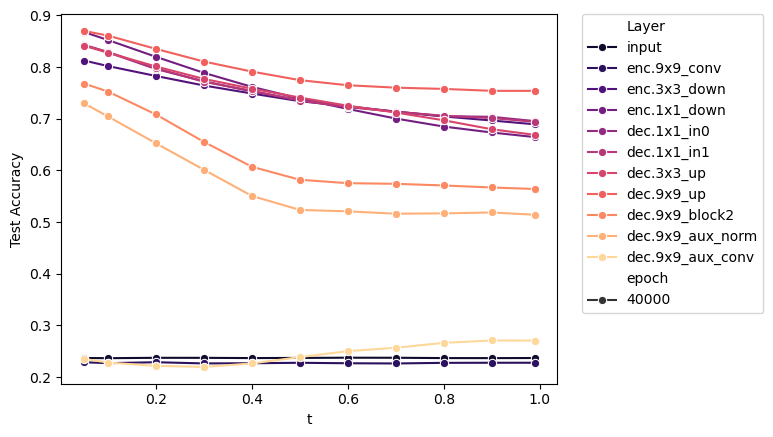

In [38]:
sns.lineplot(data=syn_df_all_big[syn_df_all_big["epoch"]==40000], marker="o",
             x="t", y="Test Accuracy", hue="Layer", style="epoch", palette="magma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)